Hello myself Jatin-Sharma . i have minor project **"Healthiness of food Prediction"**


In this project user will enter the nutritional content .. of his product and get the Nutrition SCore , telling out of 100 how much heathy  is user's product .

**Connet to Google Drive to get the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
file="/content/drive/MyDrive/Dataset_Food_Nutrition/en.openfoodfacts.org.products.tsv"

In [ ]:
df=pd.read_csv(file
,delimiter='\t')
original_df=df.copy()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Dataset_Food_Nutrition/en.openfoodfacts.org.products.tsv'

In [ ]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)

# **Data Preprocessing**

In [ ]:
original_df.head()

In [ ]:
# prompt: give me completely filled row

# Find rows where all columns have non-null values
completely_filled_rows = df.dropna()

# Print the completely filled rows
completely_filled_rows

In [ ]:
# prompt: show all columns name  with graph

# Assuming you have already loaded the dataframe 'df' as shown in your code.

# Display the column names
print("Column Names:", df.columns.tolist())

# Create a bar chart showing the number of non-null values in each column
plt.figure(figsize=(15, 15))  # Adjust figure size as needed
df.notnull().sum().plot(kind='bar')
plt.title('Number of Non-Null Values in Each Column')
plt.xlabel('Column Names')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

**Lets first define the target**
here the column

**nutrition-score-fr_100g**

**nutrition-score-uk_100g**

First we can drop rows where these 2 columns have NaN, because it will not be relevant for our model.

In [ ]:
original_df.shape

In [ ]:
print(original_df['nutrition-score-fr_100g'].isnull().sum())
print(original_df['nutrition-score-uk_100g'].isnull().sum())

Turns out NaN values were identical for both columns. Are they the same column ?

In [ ]:
original_df['nutrition-score-fr_100g'].equals(original_df['nutrition-score-uk_100g'])


they are different , lets check how much different they are


In [ ]:
diff=np.where(original_df['nutrition-score-fr_100g']==original_df['nutrition-score-uk_100g'],1,0)

# diff is array of 1, 0 where if they are equal it is represented by 1 , otherwise 0
pd.DataFrame(diff).value_counts()

# np. array dont have value counts() methods so we convert diff to dataframe

We can see that both nutriscore are quite similar. The difference is explained by the change of the formula for some categories.

Lets check which countries datas are present


In [ ]:
 original_df['countries_en'].value_counts().head(10)

In [ ]:
# prompt: make bar graph to demonstate countries

top_10_countries = original_df['countries_en'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_countries.index, y=top_10_countries.values)
plt.title('Top 10 Countries with the Most Food Products in the Dataset')
plt.xlabel('Country')
plt.ylabel('Number of Products')
plt.xticks(rotation=45, ha='right')
plt.show()

**here we can see that the US is the majority , then France , Then UK**

it is better to take
 **nutrition-score-fr_100g** over **nutrition-score-en_100g**

In [ ]:
original_df.drop(['nutrition-score-uk_100g'],axis=1,inplace=True)

So we get our **Target** , so now we will select **Relevant** **features** for our model

In [ ]:
# checking Duplicates present if any
df_clean=original_df.drop_duplicates()
print(original_df.shape)
df_clean.shape

Great,no duplicates

In [ ]:
df_clean.describe()

In [ ]:
df_clean.describe(include='object')

See, **no_nutriments** is NaN always , so now we should drop those columns that have certain Null values

In [ ]:
df_clean['no_nutriments'].isna().sum()

In [ ]:
df_clean.drop(['no_nutriments'],axis=1,inplace=True)

lets drop similiar nan columns , with a threshold of 2 percent

In [ ]:
def missing_values(df):
  missing=df.isna().sum()
  percent_missing=(missing/len(df))*100
  non_missing=df.notna().sum()
  return pd.DataFrame({'Missing':missing,'Non_Missing':non_missing,'Percent_Missing':percent_missing}).sort_values('Percent_Missing',ascending=False)

In [ ]:
missing_values(df_clean)

In [ ]:
# prompt: visualize percent missibg values

import matplotlib.pyplot as plt

# Calculate the percentage of missing values for each column
percent_missing = df_clean.isnull().sum() * 100 / len(df_clean)

# Create a bar plot of the percentage of missing values
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
plt.bar(percent_missing.index, percent_missing.values)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values per Column')
plt.show()

In [ ]:
# prompt: plot graph that greatly visualize the missing values

# Assuming 'percent_missing' is the Series you calculated earlier
plt.figure(figsize=(15, 6))
sns.heatmap(df_clean.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [ ]:
column_to_drop=missing_values(df_clean)[missing_values(df_clean)['Percent_Missing']>98].index


In [ ]:
column_to_drop

ok , they are a lot , so lets just dropp them

In [ ]:
df_clean.drop(column_to_drop,axis=1,inplace=True)

In [ ]:
df_clean.shape

We could continue to drop non relevant columns like that. But we will instead keep good columns which should be quicker. We will do so later. The purpose now is to have a general understanding.

# Selecting Relevant Columns

In [ ]:
df_clean.info()

We want to build a model predicting the nutriscore based on nutritional information.
here we have
Descriptive columns(Object)

*   Descriptive columns(Object)
*   Nutritional columns(Float)
*   the target column

# First Select Descriptive columns(Object)

In [ ]:
descriptive_columns=list()

In [ ]:
desc_col=df_clean.select_dtypes(include='object').columns

In [ ]:
df_clean[desc_col].head()

In [ ]:
df_clean[['product_name','generic_name']].isna().sum()

lets just accept product_name it is relevant for us

In [ ]:
descriptive_columns.append('product_name')

what about quantity is it relevant ?

In [ ]:
df_clean['quantity'].value_counts().head()

we dont think quantity is relevant

what about packaging , packaging_tags ?

In [ ]:
df_clean['packaging'].value_counts().head(20)


In [ ]:
df_clean['packaging_tags'].value_counts().head(20)

we dont thing it is relevant . similiary brand , brand_tags is also irrelavant


The categories column can be really interesting for us for further analysis, we keep it. But first we will see which column we will keep between : categories, categories_tags, categories_en

In [ ]:
df_clean['categories'].isna().sum()

In [ ]:
df_clean['categories_tags'].isna().sum()

In [ ]:
df_clean['categories_en'].isna().sum()

In [ ]:
print(df_clean['categories_en'].value_counts().head())
print()
print(df_clean['categories'].value_counts().head())
print()
print(df_clean['categories_tags'].value_counts().head())

catagory_en has good discription and understanding , we are selecting this


In [ ]:
descriptive_columns.append('categories_en')

In [ ]:
df_clean[desc_col].head()

In [ ]:
df_clean['origins'].value_counts().head()

In [ ]:
df_clean['origins_tags'].value_counts().head()

	origins	origins_tags	manufacturing_places	manufacturing_places_tags  are not relevant

 lets check labels,	labels_tags	,labels_en

In [ ]:
print(df_clean['labels'].value_counts().head())
print()
print(df_clean['labels_tags'].value_counts().head())
print()
print(df_clean['labels_en'].value_counts().head(20))

labels_en is good

In [ ]:
descriptive_columns.append('labels_en')

In [ ]:
df_clean['ingredients_text'].value_counts().head()


In [ ]:
df_clean['ingredients_text'].notna().sum()

it can be relevant too

In [ ]:
descriptive_columns.append('ingredients_text')

In [ ]:
df_clean['allergens'].notna().sum()

In [ ]:
df_clean['allergens'].value_counts().head(20)

they are in french so drop it for simplicity

additives_n	additives	additives_tags	additives_en ?

In [ ]:
print(df_clean['additives_n'].notna().sum())
print(df_clean['additives'].notna().sum())
print(df_clean['additives_tags'].notna().sum())
print(df_clean['additives_en'].notna().sum())

In [ ]:
print(df_clean['additives_n'].value_counts().head())
print()
print(df_clean['additives'].value_counts().head())
print()
print(df_clean['additives_tags'].value_counts().head())
print()
print(df_clean['additives_en'].value_counts().head())

addictives_en is interesting we keep it

In [ ]:
descriptive_columns.append('additives_en')

ingredients_from_palm_oil_n	ingredients_that_may_be_from_palm_oil_n	ingredients_that_may_be_from_palm_oil_tags ?

In [ ]:

print(df_clean['ingredients_that_may_be_from_palm_oil_tags'].notna().sum())

In [ ]:

print(df_clean['ingredients_that_may_be_from_palm_oil_tags'].value_counts().head())

lets just take ingredients_from_palm_oil_n

In [ ]:
descriptive_columns

In [ ]:
df_clean['states_en'].value_counts().head()

not relevant

last main_category

In [ ]:
df_clean['main_category'].value_counts().head()

In [ ]:
df_clean['main_category_en'].value_counts().head()

In [ ]:
descriptive_columns.append('main_category_en')

** now we have selected all the relevant columns that are descriptive**

In [ ]:
descriptive_columns

In [ ]:
df_new=df_clean[descriptive_columns]

# Now Nutritional columns(Float)

In [ ]:
numerical_columns=list()

In [ ]:
float_col=df_clean.select_dtypes(include='float64').columns
float_col

Considering our subject, the selection of numerical variables is only basic nutritional variables. The ones you can almost always find on the product packaging.

In [ ]:
df_clean[float_col].head()

In [ ]:
missing_values(df_clean[float_col])

1.   vitamin-d_100g
2.   vitamin-b2_100g
2.   vitamin-b1_100g
3.   vitamin-pp_100g
4.   monounsaturated-fat_100g
5.   polyunsaturated-fat_100g
6.   potassium_100g  

not including these columns because they have more than 90 percent null values


In [ ]:
type(float_col)

In [ ]:
float_col=list(float_col)

In [ ]:
remove_elements = ['vitamin-d_100g','vitamin-b2_100g','vitamin-b1_100g',
    'vitamin-pp_100g','monounsaturated-fat_100g',
    'polyunsaturated-fat_100g','potassium_100g']

In [ ]:
float_col = [x for x in float_col if x not in remove_elements]

In [ ]:
float_col

In [ ]:
df_new=pd.concat([df_new,df_clean[float_col]],axis=1)

In [ ]:
df_new.shape

In [ ]:
df_new.head()

# final Cleaning


In [ ]:
df_temp=df_new.dropna()
df_temp.shape
# dropping all nan is a very bad idea

In [ ]:
missing_values(df_new)

In [ ]:
df_new.dropna(how='all',inplace=True)
df_new.shape

In [ ]:
missing_values(df_new)

In [ ]:
df_new.head()

# **Final Cleaning part2**

In [ ]:
import missingno as msno

In [ ]:
msno.matrix(df_new)
plt.show()

In [ ]:
msno.heatmap(df_new)
plt.show()

lets just tale feature that has less missing values for our easiness
labels_en	283688
main_category_en
categories_en

we are dropping these feature because they dont allign rest of the features

In [ ]:
df_new.drop(['labels_en','main_category_en','categories_en'],axis=1,inplace=True)

In [ ]:
df_new.shape

In [ ]:
msno.matrix(df_new)
plt.show()

In [ ]:
df_new.dropna(how='all',inplace=True)
df_new.shape

In [ ]:
msno.matrix(df_new)
plt.show()

In [ ]:


threshold = 1

df_major = df_new.dropna(thresh=int(df_new.shape[1] * threshold))

df_major.shape

In [ ]:
msno.matrix(df_major)
plt.show()

we have 83037 rows , which is sufficiant for an basic models to start with

In [ ]:
missing_values(df_major)

from the box plot we can see that ,dataset dont have negative values , so , we dont need to check explicity

In [ ]:
df_major.describe()

but it has outliers , so lets deal with it

from our intuition the energy is in **kilojoules** we will take care of it later

In [ ]:


def plot_histplot_subplot(data, columns, rows, figsize=(15, 10)):
  """
  Plots a series of histplots in a subplot format using Seaborn.

  Args:
    data: Pandas DataFrame containing the data.
    columns: List of column names to plot.
    rows: Number of rows in the subplot grid.
    figsize: Tuple specifying the figure size.
  """

  fig, axes = plt.subplots(rows, int(len(columns) / rows) + (len(columns) % rows > 0), figsize=figsize)
  axes = axes.flatten()

  for i, col in enumerate(columns):
    sns.histplot(data[col], ax=axes[i])
    axes[i].set_title(col)

  plt.tight_layout()
  plt.show()


In [ ]:
sns.histplot(df_major['carbohydrates_100g'],kde=True)

In [ ]:
sns.histplot(df_major['sugars_100g'],kde=True)

**as we can see it is left skewed , so we are using IQR method to remove outliers**

In [ ]:
plt.figure(figsize=(15,15))
sns.boxplot(df_major)

In [ ]:
# prompt: count outliers in each columns

def count_outliers_iqr(df):
  """
  Counts outliers in each column of a DataFrame using the Interquartile Range (IQR) method.

  Args:
    df: Pandas DataFrame.

  Returns:
    A dictionary where keys are column names and values are the number of outliers in that column.
  """

  outlier_counts = {}
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):  # Check if the column is numeric
      Q1 = df[column].quantile(0.25)
      Q3 = df[column].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
      outlier_counts[column] = len(outliers)
  return outlier_counts

outlier_counts = count_outliers_iqr(df_major)
outlier_counts

In [ ]:

def remove_outliers_iqr(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return df_filtered
df_no_outliers = df_major.copy()
for column in df_major.select_dtypes(include=np.number).columns:
  df_no_outliers = remove_outliers_iqr(df_no_outliers, column)

df_major.shape

In [ ]:
df_no_outliers.shape

In [ ]:
plt.figure(figsize=(15,15))
sns.boxplot(df_no_outliers)

**after removing outlier we have 38052 which is greatly reduced but it can work , so lets take it , we will train both dataset, and check which one is better**




# Modeling

Now that we have our cleaned dataset, we can start to work on our model:

In [ ]:
df_no_outliers.head()

In [ ]:
df_no_outliers.shape

In [ ]:
df_no_outliers.info()

In [ ]:
df_no_outliers.describe()

lets separate target first

In [ ]:
target=df_no_outliers['nutrition-score-fr_100g']

In [ ]:
target.head()

first lets make a basic model with linear regression

First we will make our first assumptions on the model by analyzing the correlation of variables with the target

In [ ]:
numeric_columns=df_no_outliers.loc[:,df_no_outliers.dtypes!=object]
corr1=numeric_columns.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr1,annot=True)

the outcome : As we can see on the heatmap, there is a strong correlation between the columns salt_100g & sodium_100g, saturated-fat_100g & fat_100g, energy_100g & fat_100g, and carbohydrates_100g & energy_100g.
At this step of the modeling, we only want to get rid of the highly correlated features (corr>0.95).

salt_100g & sodium_100g

In [ ]:
sns.regplot(x='salt_100g',y='sodium_100g',data=df_no_outliers)

the relation is extacly equal , which is obvious because commonsalt , is equal to sodium , so to avoid redundancy , we drop any one column . correlation btw them is also 1

In [ ]:
df_no_outliers.drop('salt_100g',axis=1,inplace=True)

fat_100g & saturated-fat_100g

In [ ]:
sns.regplot(x='fat_100g',y='saturated-fat_100g',data=df_no_outliers)

In [ ]:
corr1['saturated-fat_100g']['fat_100g']

Indeed, fat is a heterogeneous group of compounds, which is one of the main constituents of food necessary to sustain the normal functions of the body. Depending on the chemical structure, this group is broadly categorized in to saturated fat and unsaturated fat in which they have differences. So, saturated fat is a component of the fat.
In fact, the saturated fat is the one used in the formula to calculate the nutriscore.
We can also watch the correlation of this 2 columns with the target and see that, the saturated fat has a better correlation with the target. This is again logical.


energy_100g & fat_100g

In [ ]:
sns.regplot(x='energy_100g',y='fat_100g',data=df_no_outliers)


If we look at the scientific meaning of our columns, we can find that carbohydrates, protein and fats provide calories (or energy).

# First
For the first model we will keep all the columns explicitly used with the formula of the nutriscore, because we know they all have a different scientific purpose and might help the model. We will add or drop columns afterward.
In fact, here is the list of variables used for the calculation :


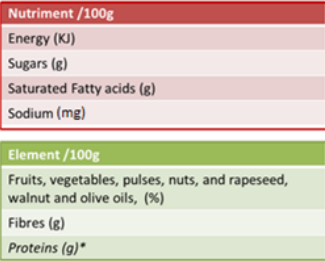

1. Sugars = carbohydrates

2. saturated fatty acids = saturated-fat
3. the only column we don't explicitly have is "fruits, vegetables, pulses, and rapeseed, walnuts and olive oils, (%). This column is really hard to calculate with the actual formula and is not an information gived on the packaging of a product. We will try to compensate the information brought by this column with our own feature engineering and adding of columns.

In [ ]:
numeric_columns.columns

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X=df_no_outliers[['energy_100g','fat_100g',
       'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g']]

Y=df_no_outliers['nutrition-score-fr_100g']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

lin_reg_1 = LinearRegression()
lin_reg_1.fit(X_train, y_train)

lin_reg_1_pred=lin_reg_1.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test,lin_reg_1_pred))
r2_score(y_test,lin_reg_1_pred)

# **Second**  with taking vitamins and all


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X=df_no_outliers[['energy_100g','fat_100g',
       'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g','vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g']]

Y=df_no_outliers['nutrition-score-fr_100g']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_train, y_train)

lin_reg_2_pred=lin_reg_2.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test,lin_reg_2_pred))
r2_score(y_test,lin_reg_2_pred)


In [ ]:
print(lin_reg_1.coef_)

In [ ]:
print(lin_reg_2.coef_)

# third
in both model there is no significant difference , lets try standardized

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features and target variable
X = df_no_outliers[['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g',
                    'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
                    'proteins_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
                    'calcium_100g', 'iron_100g']]

Y = df_no_outliers['nutrition-score-fr_100g']

# Split data before scaling
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scale features (not target) using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use transform here to avoid data leakage

# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Make predictions
lin_reg_pred = lin_reg.predict(X_test_scaled)

print(mean_squared_error(y_test, lin_reg_pred))
r2_score(y_test, lin_reg_pred)

no difference so , second one wins.

lets add palm oil

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X=df_no_outliers[[ 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n','energy_100g','fat_100g',
       'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g','vitamin-a_100g', 'vitamin-c_100g',
                    'calcium_100g', 'iron_100g']]

Y=df_no_outliers['nutrition-score-fr_100g']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

lin_reg_4 = LinearRegression()
lin_reg_4.fit(X_train, y_train)

lin_reg_4_pred=lin_reg_4.predict(X_test)


print(mean_squared_error(y_test, lin_reg_4_pred))
r2_score(y_test, lin_reg_4_pred)

it is still same , lets try to combine these two columns ,
**6th model: feature engineering on palm oil**

In [ ]:
df_no_outliers.shape

In [ ]:
df_no_outliers['ingredients_from_palm_oil_n'].value_counts().head(10)

In [ ]:
df_clean['ingredients_from_palm_oil_n'].value_counts().head(10)

In [ ]:
df_clean['ingredients_that_may_be_from_palm_oil_n'].value_counts().head(10)

In [ ]:
df_no_outliers['ingredients_that_may_be_from_palm_oil_n'].value_counts().head(10)

In [ ]:
df_major['ingredients_that_may_be_from_palm_oil_n'].value_counts().head(10)

here in our cleaned dataset df_no_outliers , these is no value added by palm_oil , its surprising but yeah , lets just drop them

In [ ]:
df_no_outliers.drop(['ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n'],axis=1,inplace=True)

lets try model with addictive_n

In [ ]:
df_no_outliers.columns

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X=df_no_outliers[['additives_n','energy_100g','fat_100g',
       'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g',
       'vitamin-a_100g', 'vitamin-c_100g','calcium_100g', 'iron_100g']]

Y=df_no_outliers['nutrition-score-fr_100g']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

lin_reg_5 = LinearRegression()
lin_reg_5.fit(X_train, y_train)

lin_reg_5_pred=lin_reg_5.predict(X_test)


print(mean_squared_error(y_test, lin_reg_5_pred))
r2_score(y_test, lin_reg_5_pred)

our model imporves little better so we take this too

# now lets deal with catagorical variables

In [ ]:
df_no_outliers.info()

In [ ]:
df_no_outliers['ingredients_text'].value_counts().head(10)

In [ ]:
df_no_outliers['additives_en'].value_counts().head()

lets find unique addictives

In [ ]:
unique_addictives=set()

for addictives in  df_no_outliers['additives_en']:
    unique_addictives.update(addictives.split(','))

unique_addictives


In [ ]:
len(unique_addictives)

there are total 288 unique addictives , great , lets try to  one_hot_encode them

In [ ]:
df_encoded=df_no_outliers.copy()
for additive in unique_addictives:
    df_encoded[additive.strip()] = df['additives_en'].apply(lambda x: 1 if pd.notna(x) and additive in x else 0)

In [ ]:
df_no_outliers.shape

In [ ]:
df_encoded.shape

In [ ]:
df_no_outliers.columns

In [ ]:
df_no_outliers.drop('additives_en',axis=1,inplace=True)


In [ ]:
df_encoded.drop('additives_en',axis=1,inplace=True)

In [ ]:
df_no_outliers.shape

In [ ]:
df_encoded.head()

finally lets train this model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df_encoded.drop(['nutrition-score-fr_100g','ingredients_text','product_name'], axis=1)
Y = df_encoded['nutrition-score-fr_100g']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

lin_reg_7 = LinearRegression()
lin_reg_7.fit(X_train, y_train)

lin_reg_7_pred = lin_reg_7.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, lin_reg_7_pred))
print("R2 Score:", r2_score(y_test, lin_reg_7_pred))


lol , thats great our accuracy is slightly better

In [ ]:

from sklearn.ensemble import RandomForestRegressor


X=df_no_outliers[['additives_n','energy_100g','fat_100g',
       'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g',
       'vitamin-a_100g', 'vitamin-c_100g','calcium_100g', 'iron_100g']]

Y=df_no_outliers['nutrition-score-fr_100g']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Random Forest Regressor
rf_reg1 = RandomForestRegressor(random_state=42)
rf_reg1.fit(X_train, y_train)
rf_reg_pred1 = rf_reg1.predict(X_test)
print("\nRandom Forest Regressor:")
print("Mean Squared Error:", mean_squared_error(y_test, rf_reg_pred1))
print("R2 Score:", r2_score(y_test, rf_reg_pred1))


**we consider this to be our final model in linear regression with accuracy 95 percent approx**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


X = df_encoded.drop(['nutrition-score-fr_100g', 'additives_n', 'ingredients_text','product_name'], axis=1)
Y = df_encoded['nutrition-score-fr_100g']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)
rf_reg_pred = rf_reg.predict(X_test)
print("\nRandom Forest Regressor:")
print("Mean Squared Error:", mean_squared_error(y_test, rf_reg_pred))
print("R2 Score:", r2_score(y_test, rf_reg_pred))


In [ ]:
import joblib

# Save a model to Google Drive
joblib.dump(lin_reg_7, '/content/drive/MyDrive/lin_reg_7.pkl')

In [ ]:
import joblib

# Save a model to Google Drive
joblib.dump(rf_reg, '/content/drive/MyDrive/random_forest.pkl')

In [ ]:
import joblib

# Load the model from Google Drive or local storage
model_path = '/content/drive/MyDrive/lin_reg_7.pkl'
lin_reg_7 = joblib.load(model_path)

In [ ]:
import joblib

# Save a model to Google Drive
joblib.dump(lin_reg_5, '/content/drive/MyDrive/linear_reg_model.pkl')
joblib.dump(df_no_outliers, '/content/drive/MyDrive/df_no_outlier.pkl')

In [ ]:
joblib.dump(df_encoded,'/content/drive/MyDrive/df_encoded.pkl')

In [ ]:
df_no_outliers.columns

In [ ]:
df_no_outliers.describe()

In [ ]:
df_no_outliers.head()

In [ ]:
import pandas as pd
import joblib
model_path = '/content/drive/MyDrive/linear_reg_model.pkl'
lin_reg_5 = joblib.load(model_path)
df_path = '/content/drive/MyDrive/df_no_outlier.pkl'
df_no_outliers = joblib.load(df_path)

rf_path='/content/drive/MyDrive/random_forest.pkl'
rf_model=joblib.load(rf_path)

In [ ]:
df_final=df_no_outliers.copy()

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X = df_final.drop(['nutrition-score-fr_100g', 'additives_n', 'ingredients_text','product_name'], axis=1)
Y = df_final['nutrition-score-fr_100g']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf_final = RandomForestRegressor(random_state=42)
rf_final.fit(X_train, y_train)
rf_final_pred = rf_final.predict(X_test)
print("\nRandom Forest Regressor:")
print("Mean Squared Error:", mean_squared_error(y_test, rf_final_pred))
print("R2 Score:", r2_score(y_test, rf_final_pred))

In [ ]:
# prompt: generate any daigram for random forest model

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming you have trained a Random Forest model named 'rf_reg'
# and you want to visualize the first decision tree in the forest

# Get the first decision tree from the forest
tree = rf_reg.estimators_[0]

# Plot the tree
plt.figure(figsize=(40, 20))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True, max_depth=3)  # Adjust max_depth as needed
plt.show()


In [ ]:
# prompt: generate a interface where user enter values , and get predicted score

#@title Prediction Interface
energy_100g = 1594.1 #@param {type:"number"}
fat_100g = 1.8 #@param {type:"number"}
saturated_fat_100g = 0.9 #@param {type:"number"}
trans_fat_100g = 0.0 #@param {type:"number"}
cholesterol_100g = 0.001 #@param {type:"number"}
carbohydrates_100g = 86 #@param {type:"number"}
sugars_100g = 47.0 #@param {type:"number"}
fiber_100g = 3.5 #@param {type:"number"}
proteins_100g = 7 #@param {type:"number"}
sodium_100g = 0.175 #@param {type:"number"}
vitamin_a_100g = 0.000790 #@param {type:"number"}
vitamin_c_100g = 0.095 #@param {type:"number"}
calcium_100g = 0.500 #@param {type:"number"}
iron_100g = 0.023 #@param {type:"number"}



input_data = pd.DataFrame({
    'energy_100g': [energy_100g],
    'fat_100g': [fat_100g],
    'saturated-fat_100g': [saturated_fat_100g],
    'trans-fat_100g': [trans_fat_100g],
    'cholesterol_100g': [cholesterol_100g],
    'carbohydrates_100g': [carbohydrates_100g],
    'sugars_100g': [sugars_100g],
    'fiber_100g': [fiber_100g],
    'proteins_100g': [proteins_100g],
    'sodium_100g': [sodium_100g],
    'vitamin-a_100g': [vitamin_a_100g],
    'vitamin-c_100g': [vitamin_c_100g],
    'calcium_100g': [calcium_100g],
    'iron_100g': [iron_100g],
})

predicted_score = rf_final.predict(input_data)

print("Predicted Nutrition Score:", predicted_score[0])

In [ ]:
joblib.dump(rf_final, '/content/drive/MyDrive/random_forest.pkl')

In [ ]:
rf_final=joblib.load('/content/drive/MyDrive/random_forest.pkl')

In [ ]:
type(rf_final)

In [ ]:
import pickle
import pandas as pd


with open('/content/drive/MyDrive/random_forest.pkl', 'rb') as model_file:
    random_forest_model = pickle.load(model_file)
print("Model loaded successfully!")
print("Model type:", type(random_forest_model))


In [ ]:
def convert_nutrition_score_to_group(nutrition_score, category):
  """Converts a nutrition score to its corresponding group based on food or beverage type.

  Args:
    nutrition_score: The nutrition score value.
    food_or_beverage: A string indicating whether it's "food" or "beverage".

  Returns:
    The corresponding group (A, B, C, D, or E) as a string.
  """

  if category == "beverage":
    if nutrition_score <= -15:
      return "A"
    elif -15 < nutrition_score <= -1:
      return "B"
    elif 2 <= nutrition_score <= 5:
      return "C"
    elif 6 <= nutrition_score <= 9:
      return "D"
    else:
      return "E"
  elif category == "food":
    if -15 <= nutrition_score <= -1:
      return "A"
    elif 0 <= nutrition_score <= 2:
      return "B"
    elif 3 <= nutrition_score <= 10:
      return "C"
    elif 11 <= nutrition_score <= 18:
      return "D"
    else:
      return "E"
  else:
    return "Invalid input"


# Example usage
nutrition_score = 11
food_or_beverage = "food"
group = convert_nutrition_score_to_group(nutrition_score, food_or_beverage)
print(f"Nutrition score {nutrition_score} for {food_or_beverage} belongs to group {group}")